In [1]:
from stable_baselines3 import PPO
from ot2_gym_wrapper import OT2Env
import gymnasium as gym
from stable_baselines3.common.evaluation import evaluate_policy
from simple_pid import PID
import matplotlib.pyplot as plt


In [2]:
env = OT2Env()

In [3]:
state = env.reset()

Best PID Gains:
X: (11.0, 0.0, 3)
Y: (16.5, 0.0, 3)
Z: (16.5, 0.0, 3)


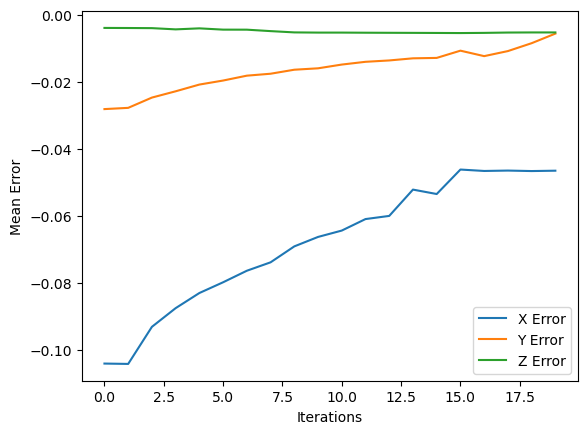

In [4]:

# Initial PID gains
initial_x_pid = PID(10, 0, 3)
initial_y_pid = PID(15, 0, 3)
initial_z_pid = PID(15, 0, 3)

# Set the setpoints for the PID controllers
initial_x_pid.setpoint = -0.16
initial_y_pid.setpoint = 0.00
initial_z_pid.setpoint = 0.16

# Lists to store errors for each axis
x_errors = []
y_errors = []
z_errors = []

# Tuning parameters
tuning_steps = 20
tuning_interval = 100

# Best-performing gains
best_gains = None
min_total_error = float('inf')

# Tuning loop
for step in range(tuning_steps):
    # Reset the environment at the beginning of each iteration
    state = env.reset()

    # Lists to store errors for each axis in the current iteration
    x_errors_iter = []
    y_errors_iter = []
    z_errors_iter = []

    # Compute control actions using PID controllers
    for _ in range(tuning_interval):
        current_position = env.sim.get_pipette_position(robotId=env.sim.robotIds[0])

        velocity_x = initial_x_pid(current_position[0])
        velocity_y = initial_y_pid(current_position[1])
        velocity_z = initial_z_pid(current_position[2])

        action = [velocity_x, velocity_y, velocity_z, 0]
        observation, reward, terminated, truncated, info = env.step(action)

        x_error = initial_x_pid.setpoint - current_position[0]
        y_error = initial_y_pid.setpoint - current_position[1]
        z_error = initial_z_pid.setpoint - current_position[2]

        x_errors_iter.append(x_error)
        y_errors_iter.append(y_error)
        z_errors_iter.append(z_error)

    # Calculate mean errors over the tuning interval
    mean_x_error = sum(x_errors_iter) / tuning_interval
    mean_y_error = sum(y_errors_iter) / tuning_interval
    mean_z_error = sum(z_errors_iter) / tuning_interval

    # Update PID gains based on the relative improvement in mean errors
    relative_improvement = 0.1  # Adjust this value as needed
    initial_x_pid.tunings = (
        initial_x_pid.Kp * (1 + relative_improvement),
        initial_x_pid.Ki * (1 + relative_improvement),
        initial_x_pid.Kd
    )
    initial_y_pid.tunings = (
        initial_y_pid.Kp * (1 + relative_improvement),
        initial_y_pid.Ki * (1 + relative_improvement),
        initial_y_pid.Kd
    )
    initial_z_pid.tunings = (
        initial_z_pid.Kp * (1 + relative_improvement),
        initial_z_pid.Ki * (1 + relative_improvement),
        initial_z_pid.Kd
    )

    # Append mean errors to the lists
    x_errors.append(mean_x_error)
    y_errors.append(mean_y_error)
    z_errors.append(mean_z_error)

    # Update best-performing gains if total error is minimized
    total_error = mean_x_error + mean_y_error + mean_z_error
    if total_error < min_total_error:
        min_total_error = total_error
        best_gains = (
            (initial_x_pid.Kp, initial_x_pid.Ki, initial_x_pid.Kd),
            (initial_y_pid.Kp, initial_y_pid.Ki, initial_y_pid.Kd),
            (initial_z_pid.Kp, initial_z_pid.Ki, initial_z_pid.Kd)
        )

# Output the best-performing gains after all iterations
print("Best PID Gains:")
print("X:", best_gains[0])
print("Y:", best_gains[1])
print("Z:", best_gains[2])

# Plot errors over time
plt.plot(x_errors, label='X Error')
plt.plot(y_errors, label='Y Error')
plt.plot(z_errors, label='Z Error')
plt.xlabel('Iterations')
plt.ylabel('Mean Error')
plt.legend()
plt.show()